# Solving for the Efficient Frontier in Stock Portfolios

<a href="TODO" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![Banner]()

The Efficient Frontier, a core concept in Harry Markowitz's Modern Portfolio Theory (MPT), is used in quantitative finance to build optimal portfolios that offer the highest expected return for a given level of risk and/or the lowest risk for a given level of return. 

It is constructed by diversifying assets to find the best risk-return trade-off. Which in this article, through python and free financial data we will find the optimal portfolio weights, that maximize expected return while minimizing portfolio variance. The result universe of assets should lie on the efficient frontier.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [348]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


Before we start, let's load two uncorrelated securities from the latest post-covid market regime (2020-2023) to build our portfolio:

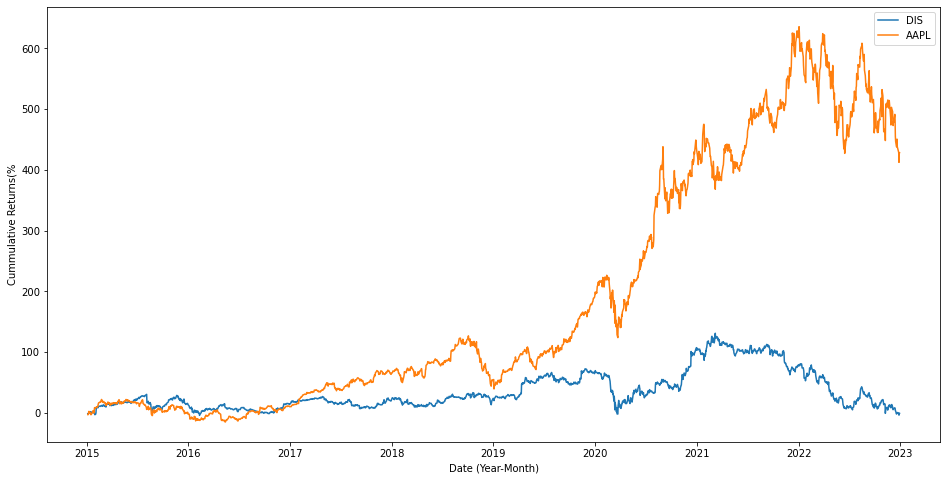

In [349]:
tickers = ["DIS", "AAPL"]

START_DATE = "2015-01-01"
END_DATE = "2022-12-31"

tickers_orig_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
tickers_df = (1 + tickers_df).cumprod() - 1

plt.figure(figsize=(16, 8))
for ticker in tickers_df.columns:
    plt.plot(tickers_df.index, tickers_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

For each stock above `(i)`, we are interested in:
- The mean historic returns, which we will use as expected returns `E(Ri)` (a naive, but common assumption in MPT).
- The variance `var(i)` and the normalized standard deviaion `sigma(i)`.
- Price weights `Xi`, which we will allocate or calculate throughout this article.

In [350]:
mean_returns = tickers_df.mean()
highest_returns = tickers_df.max()
lowest_returns = tickers_df.min()
std_deviation = tickers_df.std()
summary_table = pd.DataFrame(
    {
        "Highest ret (%)": highest_returns * 100.0,
        "Average ret (%)": mean_returns * 100.0,
        "Lowest ret (%)": lowest_returns * 100.0,
        "Deviation (%)": std_deviation * 100.0,
    }
)
summary_table.transpose()

,DIS,AAPL
Highest ret (%),131.081081,635.512761
Average ret (%),35.615841,190.274857
Lowest ret (%),-4.064403,-14.991111
Deviation (%),31.635137,201.217058


# Investment Preferences with Indifference Curves

The first building block in the efficient fontier is understanding the investors choice of risk/reward modelled through an indifference curve.
The curves model satisfaction or utility from portfolio decisions, and help to find the optimal positions to take.
We use opportunity sets, to outline viable combinations of assets' risk and returns within linear budget constraints. 

Assume the following opportunities:
1. We have a 5% risk free return (at the time of writing 11.2023)
2. We have a choice of taking no risk for 5%, or taking 40% risk for 145% gains wih AAPL.

Let's assume this is an investor with typical risk appetite, modelled by this utility function:
$$ U(x) = x + ax^2 + bx + c $$
- `x` is the risk from 1 to 100%
- `a^2` & `bx` are the quadratic (concave as we risk averse) and linear terms (positive slope, we want more returns with more risk). Their coefficients `a` & `b` will be set to `0.15` & `0.1`.
- `c` is a constant of increasing utility or satisfaction, incrementing it by 10 to create 3 curves.
The goal of the investor is to go up and to the left curves, to increase their utility. This means nothing under the `low utility` intersection, and nothing higher than `moderate utility` curve because there is no opportunity.

The optimal choice is when the opportunity set line is tangent to a curve, in our case the `moderate`, givin us 70% returns for 10% risk. 

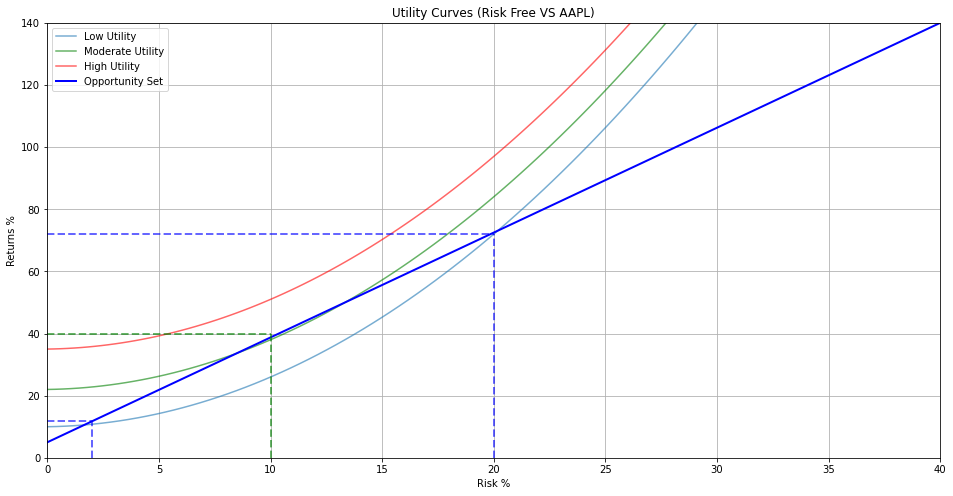

In [351]:
import matplotlib.pyplot as plt
import numpy as np


def utility_fn(x, a=0.15, b=0.1, c=1):
    return a * x**2 + b * x + c


plt.figure(figsize=(16, 8))

x_values_1 = np.linspace(0, 40, 100)
y_values_1 = utility_fn(x_values_1, c=10)
plt.plot(x_values_1, y_values_1, label="Low Utility", alpha=0.6)

x_values_2 = np.linspace(0, 35, 100)
y_values_2 = utility_fn(x_values_2, c=22)
plt.plot(x_values_2, y_values_2, label="Moderate Utility", color="g", alpha=0.6)

x_values_3 = np.linspace(0, 30, 100)
y_values_3 = utility_fn(x_values_3, c=35)
plt.plot(x_values_3, y_values_3, label="High Utility", color="r", alpha=0.6)

plt.plot([0, 40], [5, 140], label="Opportunity Set", color="b", linewidth=2)

plt.plot([2, 2], [0, 12], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([0, 2], [12, 12], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([10, 10], [0, 40], linestyle="--", color="g", alpha=0.6, linewidth=2)
plt.plot([0, 10], [40, 40], linestyle="--", color="g", alpha=0.6, linewidth=2)
plt.plot([20, 20], [0, 72], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([0, 20], [72, 72], linestyle="--", color="b", alpha=0.6, linewidth=2)

plt.xlabel("Risk %")
plt.ylabel("Returns %")
plt.title("Utility Curves (Risk Free VS AAPL)")
plt.legend()
plt.grid()

plt.xlim(0, 40)
plt.ylim(0, 140)

plt.show()

# Mean Variance portfolio

The second building block, which is wieghting our stocks according to their risk or dispertion. We will weight these and get the expected returns for our portfolios:


$$ E(R_p) = \sum_{i=1}^{N} w_{i} \cdot E(R) $$
Where:
- `E(Rp)` is the expected portfolio return, `E(R)` and `Rbar` are the same in this context.
- `E(i)` is the expected return of the asset `i`.
- `Wi` is the weight of the asset `i` in the portfolio. In this case we have only two assets.

First we convert DIS and AAP to annualized returns and covariances:
$$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + R_i) \right)^{\frac{N}{n}} - 1 $$
- `n` represents the number of data points or periods in your time series.
- `Ri` represents the returns for each period. we `+1` to get the absolute returns.
- `N` is the total number of trading days in a year (usually 252 for daily returns).

We annualized to scale up to represent a full year of risk/return, e.g.:
- Daily return: `0.005` (0.5% return)
- Annualized return: `0.005 * 252 = 1.26` (126% annualized return)

In [352]:
TRADING_DAYS_IN_YEAR = 252

tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()

rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR / len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR

summary_table = pd.DataFrame(
    {
        "Annualized Returns (%)": round(rets * 100.0, 2),
        "Annualized Covariances (%)": [
            round(cov_matrix.iloc[1, 0] * 100.0, 2),
            round(cov_matrix.iloc[0, 1] * 100.0, 2),
        ],
    }
)
summary_table.transpose()

,DIS,AAPL
Annualized Returns (%),-0.07,23.16
Annualized Covariances (%),3.84,3.84


We need to assign weights ot our assets to construct portfolios. Assuming we don't factor in the price of the asset, and purchase according to arbitrary wieghts - which we will test randomly below:

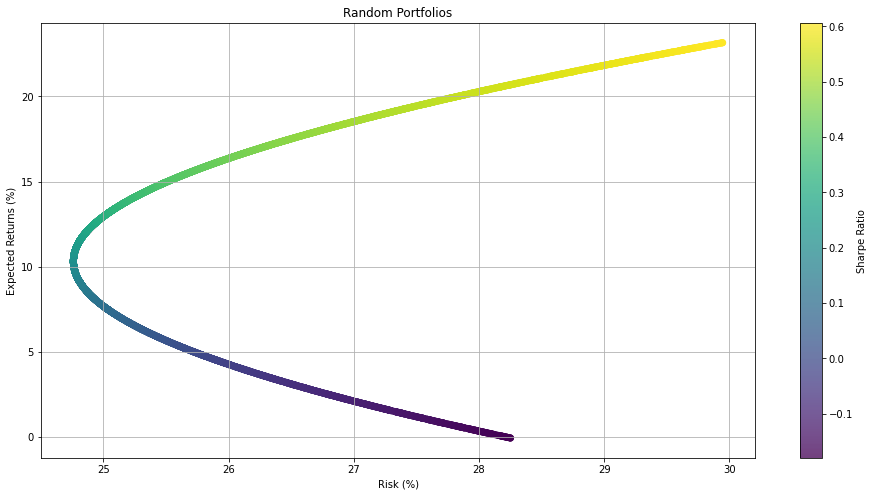

In [353]:
RISK_FREE_RATE = 0.05
MAX_PORTS = 10000


def port_generator(rets, cov_matrix):
    port_rets = []
    port_risks = []
    port_sharpes = []
    port_weights = []

    for _ in range(MAX_PORTS):
        weights = np.random.random(len(rets))
        weights /= np.sum(weights)  # Normalize weights to 1

        port_weights.append(weights)

        port_ret = np.dot(weights, rets)
        port_rets.append(port_ret)

        port_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        port_risks.append(port_risk)

        port_sharpe = (port_ret - RISK_FREE_RATE) / port_risk
        port_sharpes.append(port_sharpe)

    port_rets = np.array(port_rets)
    port_risks = np.array(port_risks)

    plt.figure(figsize=(16, 8))
    plt.scatter(
        port_risks * 100.0,
        port_rets * 100.0,
        c=port_sharpes,
        cmap="viridis",
        alpha=0.75,
    )
    plt.title("Random Portfolios")
    plt.xlabel("Risk (%)")
    plt.ylabel("Expected Returns (%)")
    plt.colorbar(label="Sharpe Ratio")
    plt.grid()

    plt.show()


port_generator(rets, cov_matrix)

You see that a frontier has formed. We also measure the Sharpe Raion, to be able to compare portfolios. The ratio tell us how if the portfolio is better than the risk free option if it's 1 or above.

The sharpe ratio:

$$ Sharpe = \frac{R_p - R_f}{\sigma_p} $$

where:
- `Rp` is the portfolio returns.
- `Rf` is the risk-free rate. As of 11.2023 this is 5%
- `sigma` is the standard deviation of the portfolio returns.

Let's add more instruments to our portfolios for realism:

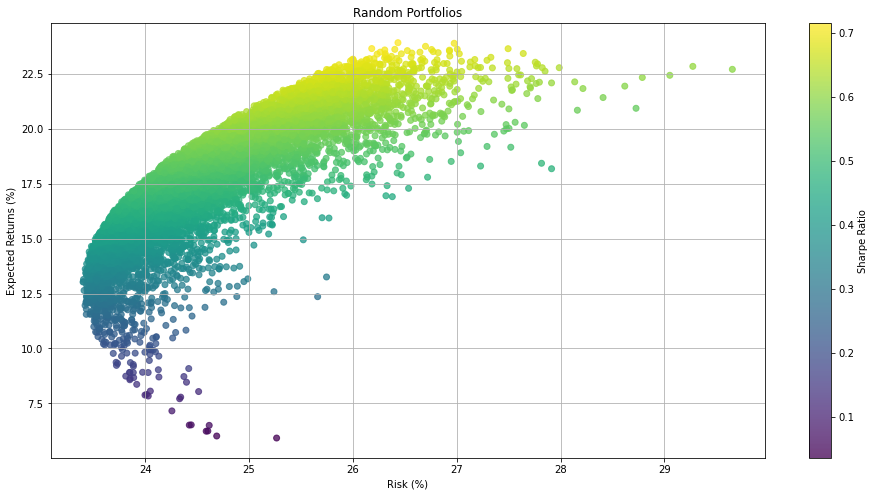

In [354]:
tickers = [
    "AAPL",
    "DIS",
    "MSFT",
    "AMZN",
    "GOOG",
]

tickers_orig_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR / len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR
port_generator(rets, cov_matrix)

$$ \text{MVP} = \frac{\sigma^{2}_j - \sigma{}_i \sigma{}_j \text{Cov(i,j)} }{\sigma^{2}_i + \sigma^{2}_j - 2 \sigma{}_i \sigma{}_j \text{Cov(i,j)}}

Now lets build 2 portfolios that will set the boundaries:
1. Minimum variance portfolio - he MVP the tip of the frontier.
2. Tangency portfolio - Market portfolio in CAPM and is the hpoint of tageny and the secutiries markett line.


In [355]:
# Equal-weighted portfolio representation
ones = np.ones(len(rets))

# COV represents movements, its inverse minimizes these
rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR / len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR
inv_cov_matrix = np.linalg.pinv(cov_matrix, hermitian=True)
min_risk_vect = ones @ inv_cov_matrix
expect_ret_vect = inv_cov_matrix @ rets

# Minimum variance portfolio
mvp_weights = min_risk_vect / np.sum(min_risk_vect)
mvp_ret = np.dot(mvp_weights, rets)
mvp_risk = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)

# Tangency
tan_weights = expect_ret_vect / np.sum(expect_ret_vect)
tan_ret = np.dot(tan_weights, rets)
tan_risk = np.sqrt(tan_weights.T @ cov_matrix @ tan_weights)
summary_data = {
    "Asset": tickers,
    "MVP Weights": mvp_weights,
    "TAN Weights": tan_weights,
}

print(f"mvp_ret: {mvp_ret}, mvp_risk {mvp_risk}")
print(f"tan_ret: {tan_ret}, tan_risk {tan_risk }")

summary_df = pd.DataFrame(summary_data)
summary_df.T

mvp_ret: 0.12755529771894913, mvp_risk 0.23392757382813026
tan_ret: 0.4974415192492174, tan_risk 0.461958733205897


,0,1,2,3,4
Asset,AAPL,DIS,MSFT,AMZN,GOOG
MVP Weights,0.160369,0.398915,0.159342,0.065706,0.215668
TAN Weights,0.600902,-0.936723,1.341301,0.359644,-0.365124


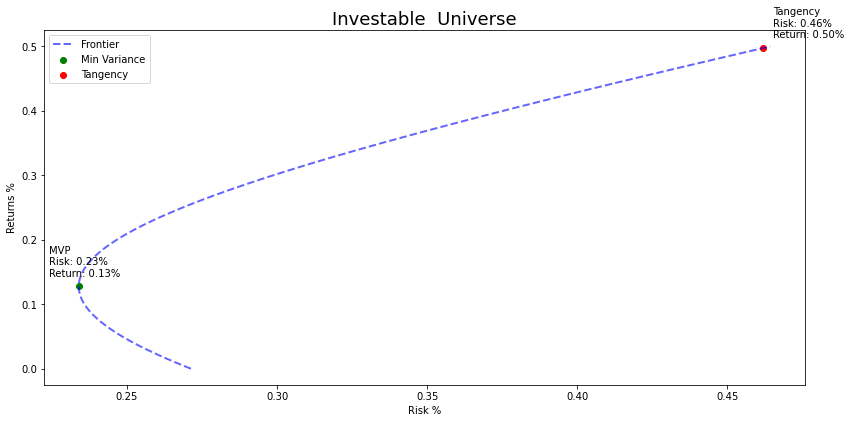

In [362]:
MAX_RETS = 0.5
TEN_BASIS_POINTS = 0.0001

exp_rets = np.arange(0, MAX_RETS, TEN_BASIS_POINTS)
rets_constant = np.sum(ones * min_risk_vect)
rets_linear = np.sum(rets * min_risk_vect)
rets_quadratic = np.sum(rets * expect_ret_vect)
utility_func = (rets_quadratic * rets_constant) - (rets_linear**2)
risk_frontier = np.sqrt(
    ((rets_constant * (exp_rets**2)) - (2 * rets_linear * exp_rets) + rets_quadratic)
    / utility_func
)

plt.figure(figsize=(12, 6))
plt.title(f"Investable  Universe", fontsize=18)

plt.plot(
    risk_frontier,
    exp_rets,
    linestyle="--",
    color="blue",
    label="Frontier",
    linewidth=2,
    alpha=0.6,
)
plt.scatter(mvp_risk, mvp_ret, color="green", label="Min Variance")
plt.annotate(
    f"MVP\nRisk: {mvp_risk:.2f}%\nReturn: {mvp_ret:.2f}%",
    (mvp_risk, mvp_ret),
    textcoords="offset points",
    xytext=(-30, 10),
)

plt.scatter(tan_risk, tan_ret, color="red", label="Tangency")
plt.annotate(
    f"Tangency\nRisk: {tan_risk:.2f}%\nReturn: {tan_ret:.2f}%",
    (tan_risk, tan_ret),
    textcoords="offset points",
    xytext=(10, 10),
)

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("Risk %")
plt.ylabel("Returns %")
plt.tight_layout()
plt.show()

Solving returns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


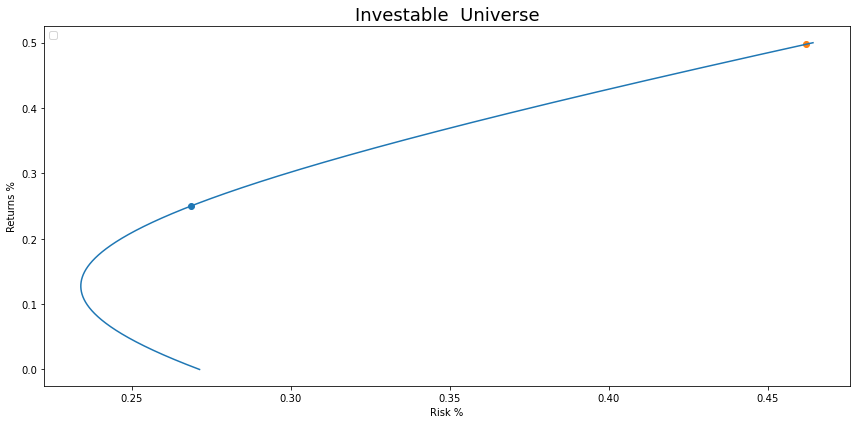

In [361]:
TARGET_RET = 0.25

pt_port = None
opt_risk = None
opt_ret = None


mvp_weights = (rets_quadratic - (rets_linear * TARGET_RET)) / utility_func
tan_weights = ((rets_constant * TARGET_RET) - rets_linear) / utility_func


opt_port = (mvp_weights * min_risk_vect) + (tan_weights * expect_ret_vect)
opt_ret = np.sum(opt_port * rets)
opt_risk = np.sqrt(
    ((rets_constant * (opt_ret**2)) - (2 * rets_linear * opt_ret) + rets_quadratic)
    / utility_func
)

plt.figure(figsize=(12, 6))
plt.title(f"Investable  Universe", fontsize=18)



plt.plot(risk_std, exp_rets)
plt.scatter(opt_risk, opt_ret)
plt.scatter(tan_risk, tan_ret)

plt.xlabel("Risk %")
plt.ylabel("Returns %")
plt.tight_layout()
plt.legend(loc="upper left", fontsize=10)
plt.show()

# Conclusion

TODO

![footer]()

## References

- https://www.investopedia.com/terms/i/indifferencecurve.asp
- https://www.investopedia.com/ask/answers/041315/how-covariance-used-portfolio-theory.asp 
- https://mathworld.wolfram.com/MatrixInverse.html


## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/oscilators-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/trading-oscillators-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.